<a href="https://colab.research.google.com/github/ixd-ai-hub/Research-Ground/blob/feature%2FCU-865d7myr5-shelf-object-detection/models/Shelf_Object_Detection_Finalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
# install SAM model
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-didazypn
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-didazypn
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 3518c86b78b3bc9cf4fbe3d18e682fad1c79dc51
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36602 sha256=0e784e647cb37fd52a39199debae82504b04777bc80e242683dd7e9d380310f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-rvzfzb31/wheels/d5/11/03/7aca746a2c0e09f279b10436ced7175926bc38f650b736a648
Successfully built segment-anything


In [ ]:
!pip install imagededup

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.6/173.6 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 96.7 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0


In [ ]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.1 MB/s eta 0:00:00


In [ ]:
# dowload SAM weights
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [ ]:
!unzip /content/base.zip -d /content/base

Archive:  /content/base.zip
   creating: /content/base/base/
  inflating: /content/base/base/bleaching.jpg  
  inflating: /content/base/base/cream.jpg  
  inflating: /content/base/base/powder.jpg  
  inflating: /content/base/base/soup.jpg  


In [ ]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [ ]:
#  Load Model
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [ ]:
#  Automatic Mask Generation
mask_generator = SamAutomaticMaskGenerator(sam)

{'bleaching': 'b', 'cream': 'r', 'powder': 'g', 'soup': 'w'}

---

In [ ]:
import matplotlib.pyplot as plt
import cv2
from matplotlib.patches import Rectangle
from PIL import Image


from imagededup.methods import CNN
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [ ]:
def load_image(path):
  image_bgr = cv2.imread(path)
  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
  return image_rgb

In [ ]:
def detect_objects(image, model, img_encoder, base_labels, base_feats, color_dict):
  # generate segmentations
  sam_result = model.generate(image)

  plt.figure(figsize=(10,12))
  for c in sam_result:
    x,y,w,h = [int(i) for i in c['bbox']]

    # plt.text(int(x), int(y), str(c['predicted_iou'])[:4])
    f = image[y:y+h, x:x+w, :]
    # print(f.shape, x,y,w,h, image_rgb.shape)
    vec = img_encoder.encode_image(image_array=f)
    sims = cosine_similarity(feats, vec)
    lbl = np.argmax(sims)
    cls = labels[lbl]
    # print(f, sims[lbl], labels[lbl])
    if sims[lbl] > 0.75:
      plt.gca().add_patch(Rectangle((x,y),w,h,linewidth=1,edgecolor=color_dict[cls],facecolor='none'))
      plt.text(int(x), int(y), cls)


  plt.imshow(image)
  plt.show()


In [ ]:
imgencoder = CNN()
encoding_map = imgencoder.encode_images(image_dir='/content/base/base')
labels, feats = [], []
for k,v in encoding_map.items():
  labels.append(k.split('.')[0])
  feats.append(v)
feats = np.array(feats)

color_dict = dict(zip(labels, ['b','r','g','w']))
# color_dict

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 173MB/s]
2023-04-15 14:32:33,663: INFO Initialized: MobileNet v3 pretrained on ImageNet dataset sliced at GAP layer
INFO:imagededup.methods.cnn:Initialized: Mobile

(720, 1280, 3)


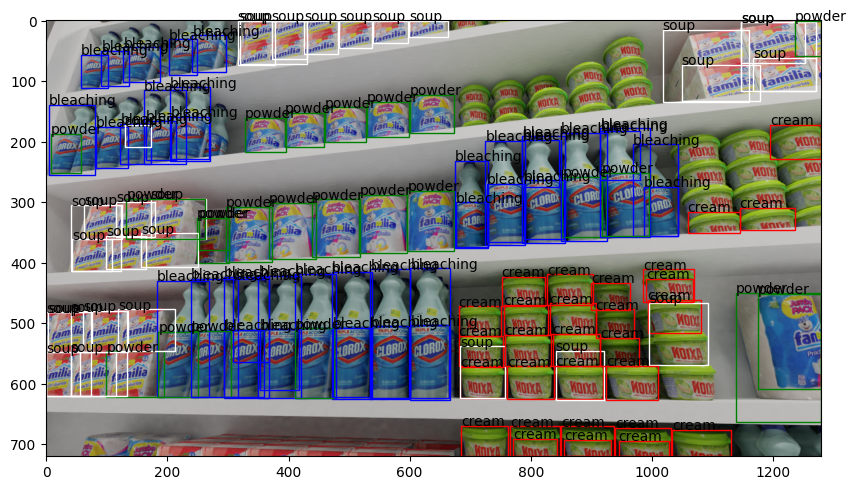

In [ ]:
IMAGE_NAME = "/content/shell4.jpg"
image_rgb = load_image(IMAGE_NAME)

detect_objects(image_rgb, mask_generator, imgencoder, labels, feats, color_dict)